## Electricity Demand Prediction
### [[Sahand]] [[Hassanizorgabad]]


The data set is provided at  https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption, which contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). The measurements are given at the minute resolution. 

The target variable is at `global_active_power` column. 

### Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

2024-07-17 17:58:27.637507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Collection

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
df = pd.read_csv(url, sep=';', compression='zip', na_values=['?'])

In [3]:
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
2075254,26/11/2010,20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2075255,26/11/2010,20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2075256,26/11/2010,21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0
2075257,26/11/2010,21:01:00,0.934,0.000,239.70,3.8,0.0,0.0,0.0


### Data Preprocessing 

In [4]:
#Setting index ro datetime 
dfcopy = df.copy()
dfcopy['datetime'] = pd.to_datetime(dfcopy['Date'] + ' ' + dfcopy['Time'] ,dayfirst=True)
dfcopy.set_index('datetime', inplace=True)
dfcopy.drop(columns=['Date', 'Time'], inplace=True)
dfcopy

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0


In [5]:
#Re-Sampling

df_h = dfcopy.resample('H').sum()
#df_h['Next_hour_GAP'] = df_h['Global_active_power'].shift(-1)
df_h

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0
...,...,...,...,...,...,...,...
2010-11-26 17:00:00,103.554,3.684,14224.18,433.0,0.0,0.0,772.0
2010-11-26 18:00:00,94.408,3.222,14251.91,397.2,0.0,0.0,0.0
2010-11-26 19:00:00,99.560,3.602,14204.46,423.4,0.0,4.0,0.0


In [6]:
# train ,test and validation data spliting

split_ratio_train = 0.8 

split_point = int(len(df_h) * split_ratio_train)
train_data = df_h.iloc[:split_point]
test_data = df_h.iloc[split_point:]

y_train = train_data['Global_active_power']
X_train = train_data.drop(columns=['Global_active_power'] )

y_test = test_data['Global_active_power']
X_test = test_data.drop(columns=['Global_active_power'] )

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#------------------------------------------------------------------
split_ratio_learn = 0.8 

split_point2 = int(len(X_train) * split_ratio_learn)
X_learn = X_train.iloc[:split_point2]
X_val = X_train.iloc[split_point2:]

y_learn = y_train.iloc[:split_point2]
y_val = y_train.iloc[split_point2:]

print(X_learn.shape, X_val.shape, y_learn.shape, y_val.shape)

(27671, 6) (6918, 6) (27671,) (6918,)
(22136, 6) (5535, 6) (22136,) (5535,)


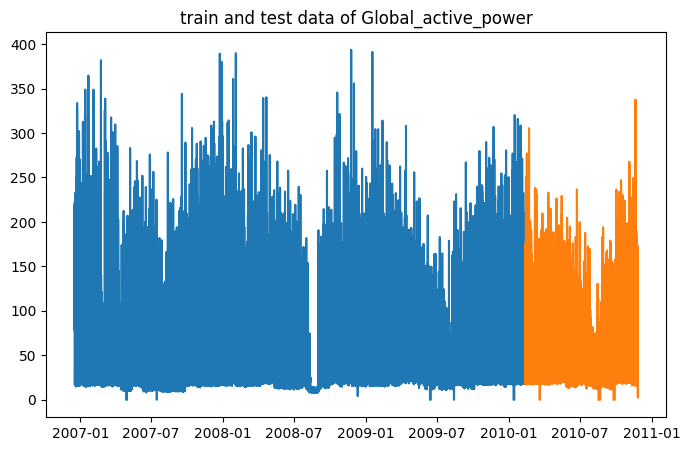

In [7]:
#Ploting train and test data of Global_active_power

plt.figure(figsize = (8, 5))
plt.plot(X_train.index, y_train)
plt.plot(X_test.index, y_test)
plt.title('train and test data of Global_active_power')
plt.show()

In [8]:
#Scaling before training

y_learn2 = y_learn.to_numpy().reshape((y_learn.shape[0], 1)).copy()
y_val2 = y_val.to_numpy()[:,None].copy()
y_test2 = y_test.to_numpy()[:,None].copy()

scaler_y = MinMaxScaler(feature_range = (0.05, 0.95))
y_learn2 = scaler_y.fit_transform(y_learn2)
y_val2 = scaler_y.transform(y_val2)
y_test2 = scaler_y.transform(y_test2)

scaler_X = MinMaxScaler(feature_range = (0.05, 0.95))
X_learn = scaler_X.fit_transform(X_learn)
X_val = scaler_X.transform(X_val)

print(type(X_learn), type(X_val), type(y_learn2), type(y_val2) , type(y_test2))
print(X_learn.shape, y_learn2.shape, X_val.shape, y_val2.shape , X_test.shape, y_test2.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(22136, 6) (22136, 1) (5535, 6) (5535, 1) (6918, 6) (6918, 1)


### Model Selection

In [14]:
#Creating train and test data Timeseries

window_size = 30
generator_learn = TimeseriesGenerator(X_learn,
                                      y_learn2,
                                      length = window_size,
                                      batch_size = 5)
generator_test = TimeseriesGenerator(X_test,
                                     y_test2,
                                     length = window_size,
                                     batch_size = 5)
generator_val = TimeseriesGenerator(X_val,
                                    y_val2,
                                    length = window_size,
                                    batch_size = 5)

#RNN with LSTM
rnn_model = keras.models.Sequential([
    keras.layers.LSTM(units = 1615, input_shape = (window_size, X_learn.shape[1])),
    keras.layers.Dense(units = 90, activation = "relu"),
    keras.layers.Dense(units = 45, activation = "relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units = 20, activation = "relu"),
    keras.layers.Dense(units = 10, activation = "relu"),
    keras.layers.Dense(units = 1)
])
rnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1615)              10478120  
                                                                 
 dense_5 (Dense)             (None, 90)                145440    
                                                                 
 dense_6 (Dense)             (None, 45)                4095      
                                                                 
 dropout_1 (Dropout)         (None, 45)                0         
                                                                 
 dense_7 (Dense)             (None, 20)                920       
                                                                 
 dense_8 (Dense)             (None, 10)                210       
                                                                 
 dense_9 (Dense)             (None, 1)                

### Model Training

In [17]:
rnn_model.compile(optimizer = "adam",
                  loss = "mean_squared_error")

early_stop = keras.callbacks.EarlyStopping(monitor = "loss", 
                                           patience = 4)

rnn_history = rnn_model.fit(generator_learn,
                            steps_per_epoch = 400,
                            epochs = 20,
                            validation_data = generator_val,
                            callbacks = [early_stop])

Epoch 1/20
400/400 [==============================] - 155s 385ms/step - loss: 0.0163 - val_loss: 0.0138
Epoch 2/20
400/400 [==============================] - 150s 376ms/step - loss: 0.0175 - val_loss: 0.0135
Epoch 3/20
400/400 [==============================] - 149s 373ms/step - loss: 0.0163 - val_loss: 0.0157
Epoch 4/20
400/400 [==============================] - 150s 375ms/step - loss: 0.0123 - val_loss: 0.0129
Epoch 5/20
400/400 [==============================] - 151s 377ms/step - loss: 0.0122 - val_loss: 0.0088
Epoch 6/20
400/400 [==============================] - 150s 374ms/step - loss: 0.0115 - val_loss: 0.0095
Epoch 7/20
400/400 [==============================] - 152s 381ms/step - loss: 0.0102 - val_loss: 0.0091
Epoch 8/20
400/400 [==============================] - 145s 363ms/step - loss: 0.0109 - val_loss: 0.0076
Epoch 9/20
400/400 [==============================] - 125s 312ms/step - loss: 0.0099 - val_loss: 0.0075
Epoch 10/20
400/400 [==============================] - 123s 307m

### Model Evaluation

For evaluation and Optimization, MSE used because, MSE is sensitive to outliers due to the squaring operation and 
MSE prioritize optimizing larger errors over smaller ones.

Also for evaluation, ploting original label with predicted label is expressible.

In [18]:
y_learn_hat = rnn_model.predict(generator_learn)
y_test_hat = rnn_model.predict(generator_test)
y_val_hat = rnn_model.predict(generator_val)

y_learn_original = scaler_y.inverse_transform(y_learn2)[:,0]
y_test_original = scaler_y.inverse_transform(y_test2)[:,0]
y_val_original = scaler_y.inverse_transform(y_val2)[:,0]

y_learn_hat_scaled = scaler_y.inverse_transform(y_learn_hat)[:,0]
y_test_hat_scaled = scaler_y.inverse_transform(y_test_hat)[:,0]
y_val_hat_scaled = scaler_y.inverse_transform(y_val_hat)[:,0]


print(y_learn_original)
print(y_learn_hat_scaled)
print()
print(y_test_original)
print(y_test_hat_scaled)
print()
print(np.sqrt(mean_squared_error(y_learn_original[window_size:], y_learn_hat_scaled)))
print(np.sqrt(mean_squared_error(y_test_original[window_size:], y_test_hat_scaled)))
print(np.sqrt(mean_squared_error(y_val_original[window_size:], y_val_hat_scaled)))

1101/1101 [==============================] - 63s 57ms/step
[152.024 217.932 204.014 ...  61.52   19.972  18.564]
[78.67333  25.254057 25.254057 ... 79.31739  78.67672  25.254057]

[28.664 39.316 86.182 ... 99.56  69.822  2.804]
[79.355606 66.16227  76.63323  ... 72.363464 76.30736  83.972275]

36.839353657211085
49.336982020113794
33.86712023725655


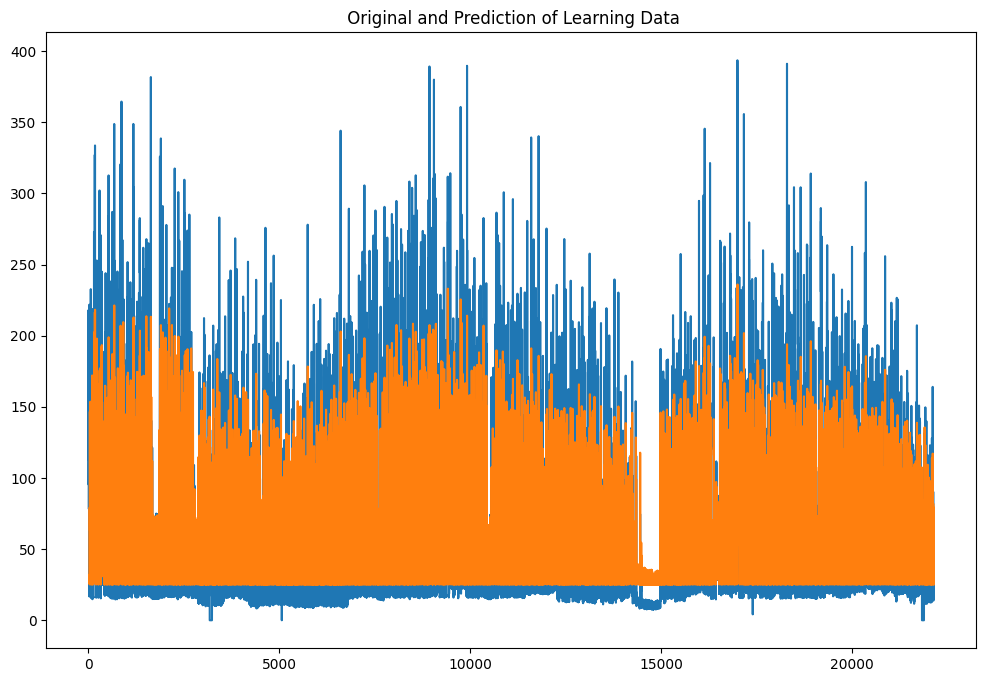

In [19]:
plt.figure(figsize = (12, 8))
plt.plot(range(len(y_learn_original)), y_learn_original)
plt.plot(np.arange(window_size, len(y_learn_original)), y_learn_hat_scaled)
plt.title(' Original and Prediction of Learning Data')
plt.show()

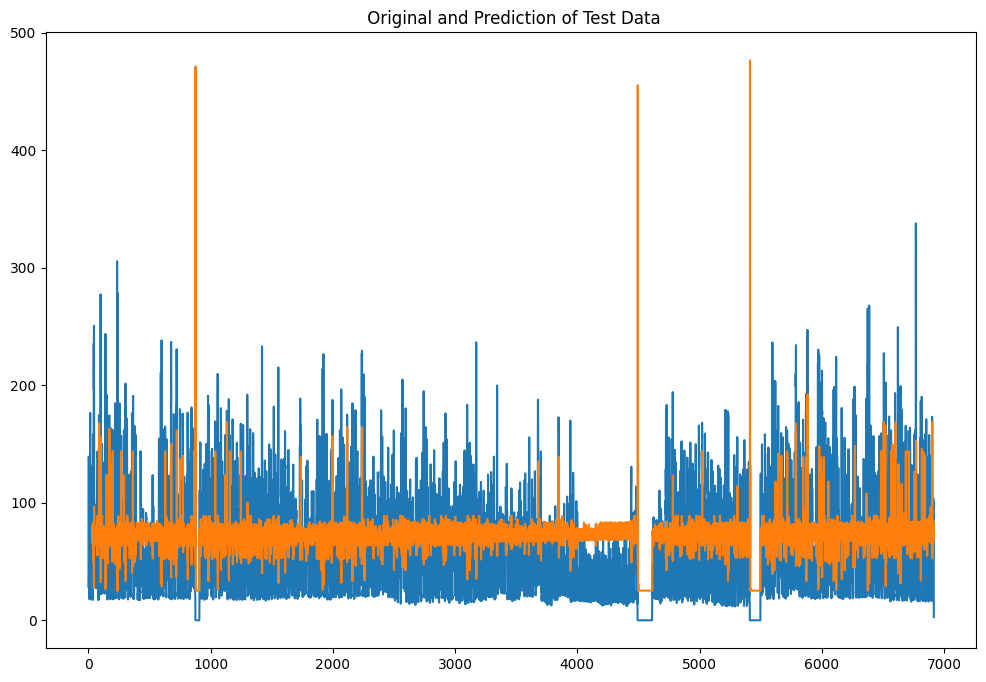

In [20]:
plt.figure(figsize = (12, 8))
plt.plot(range(len(y_test_original)), y_test_original)
plt.plot(np.arange(window_size, len(y_test_original)), y_test_hat_scaled)
plt.title(' Original and Prediction of Test Data')
plt.show()

### Make predictions for the next hour

In [21]:
last_sequence = X_test.iloc[-window_size-1:-1:1]
next_hour_prediction = rnn_model.predict(np.expand_dims(last_sequence, axis=0))
next_hour_prediction = scaler_y.inverse_transform(np.array([[next_hour_prediction[0][0]]]))[0][0]

print('\n',"Current Hour is :",X_test.index[-1],":")
print("Predicted Global Active Power for the Next Hour :", next_hour_prediction)

1/1 [==============================] - 0s 371ms/step

 Current Hour is : 2010-11-26 21:00:00 :
Predicted Global Active Power for the Next Hour : 83.97227


In [22]:
df_h.tail(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2010-11-26 17:00:00,103.554,3.684,14224.18,433.0,0.0,0.0,772.0
2010-11-26 18:00:00,94.408,3.222,14251.91,397.2,0.0,0.0,0.0
2010-11-26 19:00:00,99.560,3.602,14204.46,423.4,0.0,4.0,0.0
2010-11-26 20:00:00,69.822,3.670,14363.76,294.8,0.0,64.0,0.0
2010-11-26 21:00:00,2.804,0.000,719.07,11.4,0.0,0.0,0.0


In [23]:
time = '2010-11-26 20:00:00'
df_h.loc[time]

Global_active_power         69.822
Global_reactive_power        3.670
Voltage                  14363.760
Global_intensity           294.800
Sub_metering_1               0.000
Sub_metering_2              64.000
Sub_metering_3               0.000
Name: 2010-11-26 20:00:00, dtype: float64

In [24]:

print(df_h.shape[0])

34589


In [25]:
print(time)
df_h.index[1]

2010-11-26 20:00:00


Timestamp('2006-12-16 18:00:00')